# Splines cúbicos naturales.

**Objetivo general.** Revisar e implementar la técnica de interpolación de splines cúbicos naturales.

 <p xmlns:cc="http://creativecommons.org/ns#" xmlns:dct="http://purl.org/dc/terms/"><a property="dct:title" rel="cc:attributionURL" href="https://github.com/repomacti/macti/tree/main/notebooks/Analisis_Numerico_01">MACTI-Analisis_Numerico_01</a> by <a rel="cc:attributionURL dct:creator" property="cc:attributionName" href="https://www.macti.unam.mx">Luis M. de la Cruz</a> is licensed under <a href="http://creativecommons.org/licenses/by-sa/4.0/?ref=chooser-v1" target="_blank" rel="license noopener noreferrer" style="display:inline-block;">Attribution-ShareAlike 4.0 International<img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/cc.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/by.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/sa.svg?ref=chooser-v1"></a></p> 

**Trabajo realizado con el apoyo del Programa UNAM-DGAPA-PAPIME PE101922**

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import macti.visual as mvis

## Descripción.

La forma general de una función cúbica es:

$$
S_j(x) = a_j + b_j (x - x_j) + c_j (x - x_j)^2  +d_j (x - x_j)^3 \;\; \text{para} \;\; x_j \leq x \leq x_{j+1}
$$


Si tenemos $k+1$ puntos, tendremos entonces $k$ intervalos, y por lo tanto, $4k$ coeficientes desconocidos. 

Para encontrar los coeficientes necesitamos imponer las siguientes condiciones:

1. $S_{i + 1}(x_{i + 1}) = S_i(x_i)$ para cada $i = 0, 1, \dots, n - 2$.
2. $S_i(x_i) = f(x_i)$ y $S_i(x_{i + 1}) = f(x_{i + 1})$ para cada $i = 0, 1, \dots, n -1$.
3. $S'_{i + 1}(x_{i + 1}) = S'_i(x_i)$ para cada $i = 0, 1, \dots, n - 2$.
4. $S''_{i + 1}(x_{i + 1}) = S''_i(x_i)$ para cada $i = 0, 1, \dots, n - 2$.
5. $S''(x_0) = S''(x_n) = 0$

La deducción del algoritmo se puede encontrar en varios libros de texto, por ejemplo *Burden, R. L., Faires, J. D., & Burden, A. M. (2015). **Numerical analysis**. Cengage Learning.* 

El algoritmo es como sigue:

<img src="splinecubic.png" width=500px>

## Implementación

In [2]:
def cubic_spline(x, f):
    n = len(x) # Número total de puntos
    k = n - 1  # Número de intervalos

    # Inicialización de arreglos
    h = np.zeros(k)
    a = np.copy(f)
    b = np.zeros(k)
    c = np.zeros(k+1)
    d = np.zeros(k)
    α = np.zeros(k)
    
    # Inicialización de l, μ y z
    l = np.ones(n)
    μ = np.zeros(n)
    z = np.zeros(n)
    
    for i in range(k):
        h[i] = x[i + 1] - x[i]

    for i in range(1, k):
        α[i] = (3 / h[i]) * (a[i + 1] - a[i]) - (3 / h[i - 1]) * (a[i] - a[i - 1])
  
    for i in range(1, k):
        l[i] = 2 * (x[i + 1] - x[i - 1]) - h[i - 1] * μ[i - 1]
        μ[i] = h[i] / l[i]
        z[i] = (α[i] - h[i - 1] * z[i - 1]) / l[i]
        
    for j in range(k-1, -1, -1):
        c[j] = z[j] - μ[j]*c[j + 1]
        b[j] = (a[j + 1] - a[j]) / h[j] - h[j] * (c[j + 1] + 2 * c[j]) / 3
        d[j] = (c[j + 1] - c[j]) / (3 * h[j])
        
    return a, b, c, d

def interpola(x, z, a, b, c, d):
    """
    Interpola usando los coeficientes a, b, c y d del
    spline cúbico natural en los puntos z.
    """
    n = len(x) # Número total de puntos
    k = n - 1  # Número de intervalos

    # Arreglo para almacenar la interpolación
    y = np.zeros_like(z)

    # Recorremos todos los datos z
    for j, xj in enumerate(z):
        # Por cada intervalo se hace la interpolación cuadrática
        for i in range(k):
            if xj >= x[i] and xj <= x[i + 1]:
                y[j] = a[i] + b[i]*(xj - x[i]) + c[i]*(xj - x[i])**2 + d[i]*(xj - x[i])**3
                break
    return y

## Aplicación a un punto del ejemplo real.

Retomando el ejemplo del artículo:

<blockquote cite="https://doi.org/10.1016/j.jvolgeores.2015.09.019">
    Canet, Carles <i>et al</i>. (<b>2015</b>). Thermal history of the Acoculco geothermal system, eastern Mexico: Insights from numerical modeling and radiocarbon dating. <i>Journal of Volcanology and Geothermal Research</i>. <b>305<b>. https://doi.org/10.1016/j.jvolgeores.2015.09.019
</blockquote>
        
Leemos el conjunto de datos y los graficamos:

In [3]:
datos = pd.read_csv('T_inicial.csv')
datos

,Depth,Temp
0,0,15
1,100,113
2,200,145
3,400,178
4,710,155
5,803,201
6,1100,215
7,1200,282
8,1400,223
9,1500,226


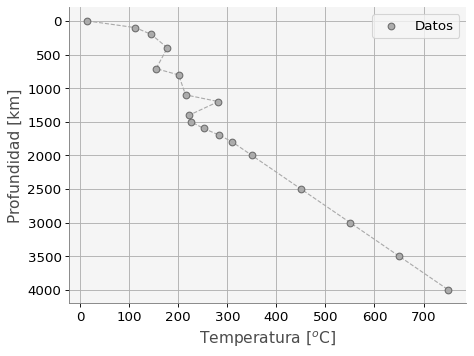

In [4]:
# Graficación de los datos 
plt.scatter(datos.Temp, datos.Depth, label='Datos',
            ec='dimgrey', fc='darkgrey', alpha=0.95, zorder=5, )
# Líneas que unen a los datos
plt.plot(datos.Temp, datos.Depth, 
         '--', color='darkgrey', lw = 1.0)

plt.gca().invert_yaxis() # Invertimos el eje y
plt.xlabel('Temperatura [$^o$C]')
plt.ylabel('Profundidad [km]')
plt.legend()
plt.grid()
plt.show()

In [5]:
# Cálculo de los coeficientes de los splines.
a, b, c, d = cubic_spline(datos.Depth, datos.Temp)

In [6]:
L = max(datos.Depth)        # Profundidad máxima
N = 99                      # Número de incógnitas
z = np.linspace(0, L, N+2)  # Coordenada z de la profundidad
yint = interpola(datos.Depth, z, a, b, c, d) # Interpolación splines cúbicos

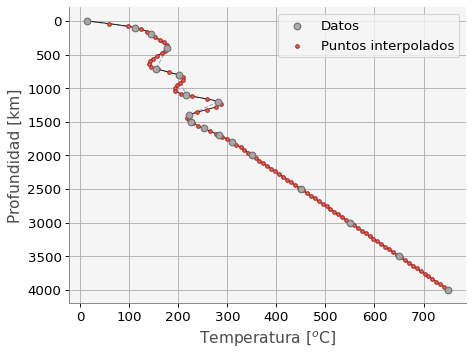

In [7]:
# Graficación de los datos 
plt.scatter(datos.Temp, datos.Depth, label='Datos',
            ec='dimgrey', fc='darkgrey', alpha=0.95, zorder=5, )
# Líneas que unen a los datos
plt.plot(datos.Temp, datos.Depth, 
         '--', color='darkgrey', lw = 1.0)

# Datos interpolados
plt.scatter(yint, z, ec='brown', fc='tomato', s = 10, zorder=3, 
            label='Puntos interpolados') 

# Gráfica de los splines cúbicos
xq = np.linspace(0,4000,500)
yq = interpola(datos.Depth, xq, a, b, c, d) 
plt.plot(yq, xq, lw = 0.75, c='k')

plt.gca().invert_yaxis()
plt.xlabel('Temperatura [$^o$C]')
plt.ylabel('Profundidad [km]')
plt.legend()
plt.grid()
plt.show()

## Interpolación usando scipy.

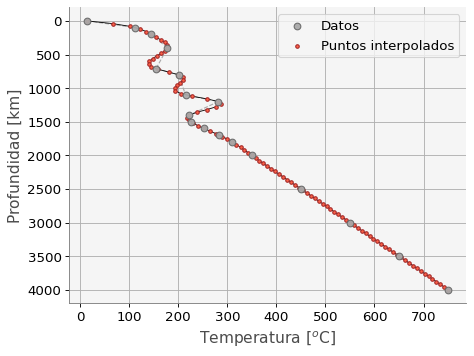

In [8]:
from scipy import interpolate

interpolador = interpolate.splrep(datos.Depth, datos.Temp, s = 0)
T_scipy = interpolate.splev(z, interpolador, der = 0)

# Graficación de los datos 
plt.scatter(datos.Temp, datos.Depth, label='Datos',
            ec='dimgrey', fc='darkgrey', alpha=0.95, zorder=5, )
# Líneas que unen a los datos
plt.plot(datos.Temp, datos.Depth, 
         '--', color='darkgrey', lw = 1.0)

# Datos interpolados
plt.scatter(T_scipy, z, ec='brown', fc='tomato', s = 10, zorder=3, 
            label='Puntos interpolados') 
plt.plot(T_scipy, z, lw = 0.75, c='k') 

plt.gca().invert_yaxis()
plt.xlabel('Temperatura [$^o$C]')
plt.ylabel('Profundidad [km]')
plt.legend()
plt.grid()
plt.show()

## Comparación entre interpolaciones

In [19]:
Error_a = np.abs(yint - T_scipy)
T_max = max(datos.Temp)
T_min = min(datos.Temp)
Error_r = np.abs(yint - T_scipy)/T_max

In [20]:
norma_Ea = np.linalg.norm(Error_a, 2)
norma_Er = np.linalg.norm(Error_r, 2)
print(f"Error absoluto : {norma_Ea}")
print(f"Error relativo : {norma_Er}")

Error absoluto : 8.081609493644324
Error relativo : 0.010775479324859097


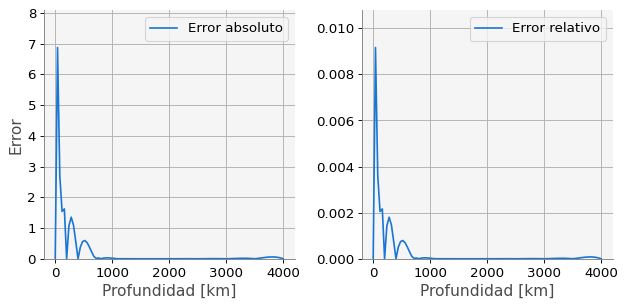

In [40]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].plot(z, Error_a, label="Error absoluto")
#ax[0].set_ylim(0, T_max)
ax[0].set_ylim(0, norma_Ea)
ax[0].set_ylabel('Error')
ax[0].set_xlabel('Profundidad [km]')
ax[0].grid()
ax[0].legend()

ax[1].plot(z, Error_r, label="Error relativo")
ax[1].set_ylim(0, norma_Er)
ax[1].set_xlabel('Profundidad [km]')
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()

In [42]:
compara = pd.DataFrame(np.array([yint, T_scipy, Error_a, Error_r]).T,
                      columns =['spline', 'scipy', 'E. abs.', 'E. rel.'])
compara

,spline,scipy,E. abs.,E. rel.
0,15.000000,15.000000,1.776357e-15,2.368476e-18
1,59.937118,66.806893,6.869775e+00,9.159700e-03
2,98.317530,101.023446,2.705917e+00,3.607889e-03
3,123.876117,122.336554,1.539564e+00,2.052752e-03
4,137.054294,135.433107,1.621187e+00,2.161582e-03
...,...,...,...,...
96,718.015515,718.073685,5.816974e-02,7.755965e-05
97,726.012217,726.064707,5.248936e-02,6.998581e-05
98,734.008421,734.049846,4.142437e-02,5.523249e-05
99,742.004294,742.028483,2.418963e-02,3.225284e-05


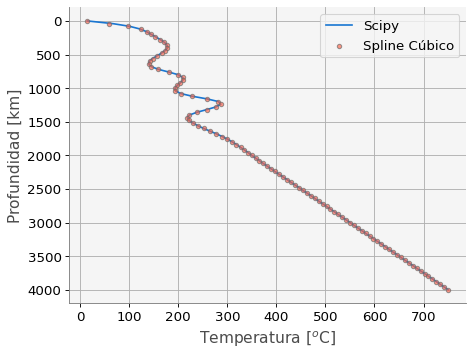

In [43]:
plt.plot(T_scipy, z, lw=1.5, label ="Scipy")
plt.scatter(yint, z, ec="dimgray", fc="tomato", s=15, alpha=0.65, zorder = 5, label="Spline Cúbico")
plt.gca().invert_yaxis()
plt.xlabel('Temperatura [$^o$C]')
plt.ylabel('Profundidad [km]')
plt.legend()
plt.grid()
plt.show()